In [2]:
import pandas as pd

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pickle5 as pickle
import os
import re
# turn of warnings for this notebook
import warnings
warnings.filterwarnings('ignore')

print(tf.__version__)

1.14.0


# Neural Net Ensemble
 - Build a somewhat basic NN to account for grid locations and month to possibly handle non-linearities and get a better fitting ensemble model than OLS provided
 - Ultimately NN approach for the ensemble didn't lead to noticeably better performance than the linear models, and in many cases probably overfit on the 2013-2014 "dev" data. This notebook illustrates one that performed decently.

## Read in Data

In [4]:
# catdef_test_df.pkly created and written in the OLS Ensemble notebook
with open('catdef_test_df.pkl', 'rb') as f:
     catdef_test_df = pickle.load(f)
    
catdef_test_df.head()

,Year,Month,catdef,arima_preds,clstm_preds,Year-Month
0,2013,4,"[[nan, nan, nan, 85.939, 109.03, 122.28, 143.5...","[[nan, nan, nan, 66.7398951814242, 88.67098509...","[[nan, nan, nan, 85.938576, 103.544174, 110.91...",2013-4
1,2013,5,"[[nan, nan, nan, 147.88, 181.63, 188.63, 204.6...","[[nan, nan, nan, 102.339907836972, 129.2146757...","[[nan, nan, nan, 130.21872, 160.34409, 169.394...",2013-5
2,2013,6,"[[nan, nan, nan, 121.71, 163.49, 194.99, 225.6...","[[nan, nan, nan, 123.906814370616, 154.6877450...","[[nan, nan, nan, 143.92606, 181.17183, 192.075...",2013-6
3,2013,7,"[[nan, nan, nan, 167.07, 230.01, 264.82, 299.2...","[[nan, nan, nan, 157.88604967341, 205.76766306...","[[nan, nan, nan, 203.37497, 250.97179, 261.521...",2013-7
4,2013,8,"[[nan, nan, nan, 257.66, 324.35, 333.35, 360.3...","[[nan, nan, nan, 210.33331801029, 276.03185249...","[[nan, nan, nan, 240.79918, 287.63943, 295.043...",2013-8


In [5]:
# All_Predictions.csv created and written in the OLS Ensemble notebook
ap = pd.read_csv("All_Predictions.csv")
ap

,actual_catdef,arima_pred,clstm_pred,Month,Year,Coordinates
0,85.939,66.739895,85.938576,4,2013,"0, 3"
1,109.030,88.670985,103.544174,4,2013,"0, 4"
2,122.280,105.710309,110.915080,4,2013,"0, 5"
3,143.500,113.746098,123.457630,4,2013,"0, 6"
4,148.690,120.348041,123.816000,4,2013,"0, 7"
...,...,...,...,...,...,...
10555,401.030,400.607547,394.102660,9,2016,"32, 26"
10556,400.280,405.591886,391.482000,9,2016,"32, 27"
10557,402.660,397.354142,404.192400,9,2016,"32, 28"
10558,478.280,486.180000,466.108400,9,2016,"32, 29"


In [6]:
# split x/y coords into their own measurements
ap[['Coord_x', 'Coord_y']] = ap['Coordinates'].str.split(', ', expand=True)
ap

,actual_catdef,arima_pred,clstm_pred,Month,Year,Coordinates,Coord_x,Coord_y
0,85.939,66.739895,85.938576,4,2013,"0, 3",0,3
1,109.030,88.670985,103.544174,4,2013,"0, 4",0,4
2,122.280,105.710309,110.915080,4,2013,"0, 5",0,5
3,143.500,113.746098,123.457630,4,2013,"0, 6",0,6
4,148.690,120.348041,123.816000,4,2013,"0, 7",0,7
...,...,...,...,...,...,...,...,...
10555,401.030,400.607547,394.102660,9,2016,"32, 26",32,26
10556,400.280,405.591886,391.482000,9,2016,"32, 27",32,27
10557,402.660,397.354142,404.192400,9,2016,"32, 28",32,28
10558,478.280,486.180000,466.108400,9,2016,"32, 29",32,29


In [7]:
# split to dev and test data
dev_df = ap[ap['Year'] < 2015]
test_df = ap[ap['Year'] > 2014]
print(dev_df.shape)
print(test_df.shape)

(5280, 8)
(5280, 8)


In [8]:
# change df to arrays of feature/target for dev and feature array for test
#dev_X = dev_df.drop(['actual_catdef', 'Year', 'Coordinates', 'Coord_x', 'Coord_y'], axis = 1).values
dev_X = dev_df.drop(['actual_catdef', 'Year', 'Coordinates'], axis = 1).values
dev_Y = dev_df['actual_catdef'].values

#test_X = test_df.drop(['actual_catdef', 'Year', 'Coordinates', 'Coord_x', 'Coord_y'], axis = 1).values
test_X = test_df.drop(['actual_catdef', 'Year', 'Coordinates'], axis = 1).values

print(dev_X.shape)
print(dev_Y.shape)
print(test_X.shape)

(5280, 5)
(5280,)
(5280, 5)


## Create NN Ensemble Model

In [9]:
def ens_model():
    # create model
    model = keras.Sequential()
    model.add(keras.layers.Dense(24, 
                                 input_dim=5, 
                                 #kernel_initializer='normal', 
                                 activation='relu'))
    model.add(keras.layers.Dense(12, 
                                 #kernel_initializer='normal', 
                                 activation='relu'))
    model.add(keras.layers.Dense(6, 
                                 #kernel_initializer='normal', 
                                 activation='relu'))
    model.add(keras.layers.Dense(1, 
                                 #kernel_initializer='normal'
                                ))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [10]:
# fit model
estimator = keras.wrappers.scikit_learn.KerasRegressor(build_fn=ens_model, 
                                                       epochs=50, 
                                                       #batch_size=200, 
                                                       verbose=0)
estimator.fit(dev_X, dev_Y)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
# make predictions on test data (2015-2016)
predictions = estimator.predict(test_X)
predictions[:15]

array([121.30362, 149.76991, 163.38234, 197.71077, 201.97902, 135.91151,
       269.25095, 494.91638, 625.8279 , 659.88385, 845.97565, 709.79803,
       121.03555, 134.87193, 146.65031], dtype=float32)

In [12]:
# put predictions onto test_df for evaluation
test_df['ens_predicted_catdef'] = predictions
test_df

,actual_catdef,arima_pred,clstm_pred,Month,Year,Coordinates,Coord_x,Coord_y,ens_predicted_catdef
5280,107.42,95.308787,102.63298,4,2015,"0, 3",0,3,121.303619
5281,129.48,111.618985,136.30745,4,2015,"0, 4",0,4,149.769913
5282,143.92,128.346665,149.46742,4,2015,"0, 5",0,5,163.382339
5283,191.05,167.711591,182.34052,4,2015,"0, 6",0,6,197.710770
5284,206.67,173.657163,187.42105,4,2015,"0, 7",0,7,201.979019
...,...,...,...,...,...,...,...,...,...
10555,401.03,400.607547,394.10266,9,2016,"32, 26",32,26,420.649017
10556,400.28,405.591886,391.48200,9,2016,"32, 27",32,27,419.003815
10557,402.66,397.354142,404.19240,9,2016,"32, 28",32,28,425.818329
10558,478.28,486.180000,466.10840,9,2016,"32, 29",32,29,497.164581


In [13]:
# need year-month to merge w/ other data
test_df['Year-Month'] = test_df['Year'].astype(str) + '-' + test_df['Month'].astype(str)
test_df

,actual_catdef,arima_pred,clstm_pred,Month,Year,Coordinates,Coord_x,Coord_y,ens_predicted_catdef,Year-Month
5280,107.42,95.308787,102.63298,4,2015,"0, 3",0,3,121.303619,2015-4
5281,129.48,111.618985,136.30745,4,2015,"0, 4",0,4,149.769913,2015-4
5282,143.92,128.346665,149.46742,4,2015,"0, 5",0,5,163.382339,2015-4
5283,191.05,167.711591,182.34052,4,2015,"0, 6",0,6,197.710770,2015-4
5284,206.67,173.657163,187.42105,4,2015,"0, 7",0,7,201.979019,2015-4
...,...,...,...,...,...,...,...,...,...,...
10555,401.03,400.607547,394.10266,9,2016,"32, 26",32,26,420.649017,2016-9
10556,400.28,405.591886,391.48200,9,2016,"32, 27",32,27,419.003815,2016-9
10557,402.66,397.354142,404.19240,9,2016,"32, 28",32,28,425.818329,2016-9
10558,478.28,486.180000,466.10840,9,2016,"32, 29",32,29,497.164581,2016-9


In [14]:
# build out predictions into arrays, add month/year to merge with existing data
pred_df_list = []
for ym in test_df['Year-Month'].unique():
    output_row = {}
    
    # get year/month to match with og data
    yr, mo = ym.split('-')
    output_row['Year'] = yr
    output_row['Month'] = mo
    
    # break rows into list of dicts
    sub_df = test_df[test_df['Year-Month']==ym]
    pred_dicts = sub_df.to_dict('records')
    
    # create array of nans to populate
    a = np.empty((33,37))
    a[:] = np.nan
    
    # populate with point predictions
    for p in pred_dicts:
        coord_y, coord_x = p['Coordinates'].split(', ')
        a[int(coord_y), int(coord_x)] = p['ens_predicted_catdef']
        
    output_row['ensemble_pred_catdef'] = a
    
    pred_df_list.append(output_row)
    
predictions_array_df = pd.DataFrame(pred_df_list)
predictions_array_df

,Year,Month,ensemble_pred_catdef
0,2015,4,"[[nan, nan, nan, 121.30361938476562, 149.76991..."
1,2015,5,"[[nan, nan, nan, 154.60760498046875, 182.76081..."
2,2015,6,"[[nan, nan, nan, 196.24082946777344, 234.82823..."
3,2015,7,"[[nan, nan, nan, 255.60520935058594, 301.48779..."
4,2015,8,"[[nan, nan, nan, 294.47900390625, 337.00936889..."
5,2015,9,"[[nan, nan, nan, 300.1143798828125, 336.879241..."
6,2016,4,"[[nan, nan, nan, 99.98690795898438, 117.528388..."
7,2016,5,"[[nan, nan, nan, 131.8679656982422, 154.728210..."
8,2016,6,"[[nan, nan, nan, 171.28663635253906, 203.13949..."
9,2016,7,"[[nan, nan, nan, 237.58447265625, 284.13369750..."


<AxesSubplot:>

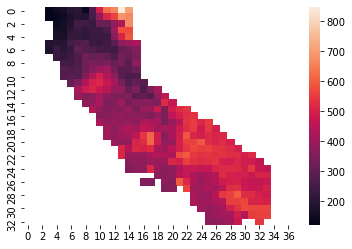

In [15]:
sns.heatmap(predictions_array_df['ensemble_pred_catdef'][0])

In [16]:
# create year_month again to merge on
predictions_array_df['Year-Month'] = predictions_array_df['Year'].astype(str) + '-' + predictions_array_df['Month'].astype(str)
catdef_test_df['Year-Month'] = catdef_test_df['Year'].astype(str) + '-' + catdef_test_df['Month'].astype(str)


final_pred_df = catdef_test_df[catdef_test_df['Year'] > 2014]
final_pred_df = final_pred_df.merge(predictions_array_df, on = ['Year-Month'])
print(final_pred_df.shape)
final_pred_df.drop(['Year-Month', 'Year_y', 'Month_y'], axis = 1, inplace=True)
final_pred_df.rename(columns={'Year_x': 'Year', 'Month_x': 'Month'}, inplace=True)
final_pred_df

(12, 9)


,Year,Month,catdef,arima_preds,clstm_preds,ensemble_pred_catdef
0,2015,4,"[[nan, nan, nan, 107.42, 129.48, 143.92, 191.0...","[[nan, nan, nan, 95.3087869354875, 111.6189852...","[[nan, nan, nan, 102.63298, 136.30745, 149.467...","[[nan, nan, nan, 121.30361938476562, 149.76991..."
1,2015,5,"[[nan, nan, nan, 153.2, 176.08, 180.45, 219.26...","[[nan, nan, nan, 135.658782430562, 143.9159212...","[[nan, nan, nan, 126.4272, 163.32512, 175.3835...","[[nan, nan, nan, 154.60760498046875, 182.76081..."
2,2015,6,"[[nan, nan, nan, 205.2, 244.07, 247.32, 278.63...","[[nan, nan, nan, 138.476067407405, 172.4432124...","[[nan, nan, nan, 178.0037, 218.895, 227.39644,...","[[nan, nan, nan, 196.24082946777344, 234.82823..."
3,2015,7,"[[nan, nan, nan, 273.9, 321.28, 321.4, 349.65,...","[[nan, nan, nan, 180.93178138614, 238.64429423...","[[nan, nan, nan, 237.80673, 278.65698, 283.539...","[[nan, nan, nan, 255.60520935058594, 301.48779..."
4,2015,8,"[[nan, nan, nan, 317.01, 343.39, 338.89, 368.6...","[[nan, nan, nan, 244.399689124637, 298.5787650...","[[nan, nan, nan, 259.86298, 300.0705, 303.2366...","[[nan, nan, nan, 294.47900390625, 337.00936889..."
5,2015,9,"[[nan, nan, nan, 321.16, 341.78, 335.53, 367.5...","[[nan, nan, nan, 272.330259782286, 316.9433841...","[[nan, nan, nan, 250.1424, 281.01056, 283.0671...","[[nan, nan, nan, 300.1143798828125, 336.879241..."
6,2016,4,"[[nan, nan, nan, 88.51700000000001, 113.08, 12...","[[nan, nan, nan, 68.6571506461656, 88.14016892...","[[nan, nan, nan, 83.53611, 101.039925, 109.106...","[[nan, nan, nan, 99.98690795898438, 117.528388..."
7,2016,5,"[[nan, nan, nan, 133.52, 158.02, 159.95, 180.0...","[[nan, nan, nan, 109.343312793199, 136.8057345...","[[nan, nan, nan, 106.92795, 127.431435, 135.15...","[[nan, nan, nan, 131.8679656982422, 154.728210..."
8,2016,6,"[[nan, nan, nan, 185.22, 225.34, 235.22, 259.7...","[[nan, nan, nan, 144.240360078723, 178.4164686...","[[nan, nan, nan, 142.70375, 173.88017, 183.376...","[[nan, nan, nan, 171.28663635253906, 203.13949..."
9,2016,7,"[[nan, nan, nan, 236.88, 285.07, 296.07, 319.8...","[[nan, nan, nan, 195.884413571035, 247.9642808...","[[nan, nan, nan, 206.66916, 252.26588, 261.685...","[[nan, nan, nan, 237.58447265625, 284.13369750..."


## Format and plot data

<AxesSubplot:>

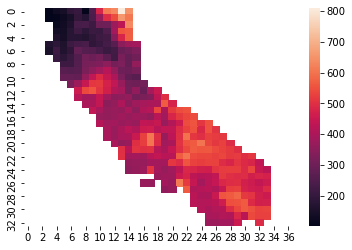

In [17]:
# creates CA grid to mask for CA data below
check_grid = np.zeros((33,37))
counter = 0
for fn in os.listdir('catdef_extraction_6mo_lambda/'):
    if fn.endswith('.preds.csv'):
        # extract x and y coords from filename
        reg_x = re.search('row.(\d+)', fn)
        coord_x = int(reg_x.group(1))

        reg_y = re.search('col.(\d+)', fn)
        coord_y = int(reg_y.group(1))
        
        check_grid[coord_x, coord_y] = 1


# created catdef only for predicted gridpoints
def apply_mask(arr):
    # Note: uses check_grid defined earlier
    m_arr = arr * check_grid
    m_arr[m_arr==0] = ['nan']
    
    return m_arr

final_pred_df['catdef_masked'] = final_pred_df['catdef'].apply(apply_mask)
sns.heatmap(final_pred_df['catdef_masked'][0])

<AxesSubplot:>

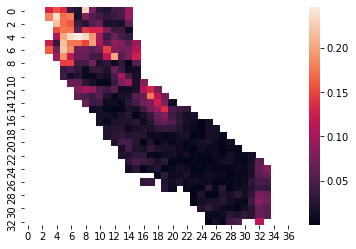

In [18]:
final_pred_df['arima_error'] = abs((final_pred_df['arima_preds'] - final_pred_df['catdef_masked']) / final_pred_df['catdef_masked'])
final_pred_df['clstm_error'] = abs((final_pred_df['clstm_preds'] - final_pred_df['catdef_masked']) / final_pred_df['catdef_masked'])  
final_pred_df['ensemble_error'] = abs((final_pred_df['ensemble_pred_catdef'] - final_pred_df['catdef_masked']) / final_pred_df['catdef_masked'])

sns.heatmap(final_pred_df['ensemble_error'][0])

## Plot/Evaluate Error

In [19]:
# Plotting Function
###################
def plot_mape(df, year, title):
    sub_df = df[df['Year'] == year].copy()
    sub_df.reset_index(inplace=True, drop=True)

    fig, axs = plt.subplots(3, 6, figsize = (18,15))
    plt.suptitle(title)
    ###################################################################################################
    # First row of plots
    ###################################################################################################
    # Arima MAPE Prediction Errors
    sns.heatmap(sub_df['arima_error'][0], 
                cmap='YlOrRd',
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[0,0], 
                xticklabels=False, yticklabels=False)
    # Calculate MAPE
    mape = round(np.nanmean(sub_df['arima_error'][0]) * 100, 1)
    axs[0,0].set(xlabel='April', ylabel='Arima Predictions', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['arima_error'][1], 
                cmap='YlOrRd',
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[0,1], 
                xticklabels=False, yticklabels=False)
    # Calculate MAPE
    mape = round(np.nanmean(sub_df['arima_error'][1]) * 100, 1)
    axs[0,1].set(xlabel='May', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['arima_error'][2], 
                cmap='YlOrRd', 
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[0,2], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['arima_error'][2]) * 100, 1)
    axs[0,2].set(xlabel='June', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['arima_error'][3], 
                cmap='YlOrRd', 
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[0,3], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['arima_error'][3]) * 100, 1)
    axs[0,3].set(xlabel='July', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['arima_error'][4], 
                cmap='YlOrRd', 
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[0,4], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['arima_error'][4]) * 100, 1)
    axs[0,4].set(xlabel='August', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['arima_error'][5], 
                cmap='YlOrRd', 
                vmin=0, vmax=.5, 
                ax=axs[0,5], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['arima_error'][5]) * 100, 1)
    axs[0,5].set(xlabel='September', title='MAPE ' + str(mape) + '%')

    ###################################################################################################
    # Second row of plots
    ###################################################################################################
    # Arima MAPE Prediction Errors
    sns.heatmap(sub_df['clstm_error'][0], 
                cmap='YlOrRd', 
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[1,0], 
                xticklabels=False, yticklabels=False)
    # Calculate MAPE
    mape = round(np.nanmean(sub_df['clstm_error'][0]) * 100, 1)
    axs[1,0].set(xlabel='April', ylabel='ConvLSTM Predictions', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['clstm_error'][1], 
                cmap='YlOrRd',
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[1,1], 
                xticklabels=False, yticklabels=False)
    # Calculate MAPE
    mape = round(np.nanmean(sub_df['clstm_error'][1]) * 100, 1)
    axs[1,1].set(xlabel='May', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['clstm_error'][2], 
                cmap='YlOrRd', 
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[1,2], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['clstm_error'][2]) * 100, 1)
    axs[1,2].set(xlabel='June', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['clstm_error'][3], 
                vmin=0, vmax=.5, 
                cmap='YlOrRd', 
                cbar=False, 
                ax=axs[1,3], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['clstm_error'][3]) * 100, 1)
    axs[1,3].set(xlabel='July', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['clstm_error'][4], 
                cmap='YlOrRd', 
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[1,4], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['clstm_error'][4]) * 100, 1)
    axs[1,4].set(xlabel='August', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['clstm_error'][5], 
                cmap='YlOrRd', 
                vmin=0, vmax=.5, 
                ax=axs[1,5], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['clstm_error'][5]) * 100, 1)
    axs[1,5].set(xlabel='September', title='MAPE ' + str(mape) + '%')


    ###################################################################################################
    # Third row of plots
    ###################################################################################################
    # Arima MAPE Prediction Errors
    sns.heatmap(sub_df['ensemble_error'][0], 
                cmap='YlOrRd', 
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[2,0], 
                xticklabels=False, yticklabels=False)
    # Calculate MAPE
    mape = round(np.nanmean(sub_df['ensemble_error'][0]) * 100, 1)
    axs[2,0].set(xlabel='April', ylabel='Ensemble Predictions', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['ensemble_error'][1], 
                cmap='YlOrRd',
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[2,1], 
                xticklabels=False, yticklabels=False)
    # Calculate MAPE
    mape = round(np.nanmean(sub_df['ensemble_error'][1]) * 100, 1)
    axs[2,1].set(xlabel='May', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['ensemble_error'][2],
                cmap='YlOrRd',
                vmin=0, vmax=.5, 
                cbar=False, 
                ax=axs[2,2], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['ensemble_error'][2]) * 100, 1)
    axs[2,2].set(xlabel='June', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['ensemble_error'][3], 
                vmin=0, vmax=.5,
                cmap='YlOrRd',
                cbar=False, 
                ax=axs[2,3], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['ensemble_error'][3]) * 100, 1)
    axs[2,3].set(xlabel='July', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['ensemble_error'][4], 
                vmin=0, vmax=.5,
                cmap='YlOrRd',
                cbar=False, 
                ax=axs[2,4], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['ensemble_error'][4]) * 100, 1)
    axs[2,4].set(xlabel='August', title='MAPE ' + str(mape) + '%')

    sns.heatmap(sub_df['ensemble_error'][5],
                cmap='YlOrRd',
                vmin=0, vmax=.5, 
                ax=axs[2,5], 
                xticklabels=False, yticklabels=False)
    mape = round(np.nanmean(sub_df['ensemble_error'][5]) * 100, 1)
    axs[2,5].set(xlabel='September', title='MAPE ' + str(mape) + '%')

    print()

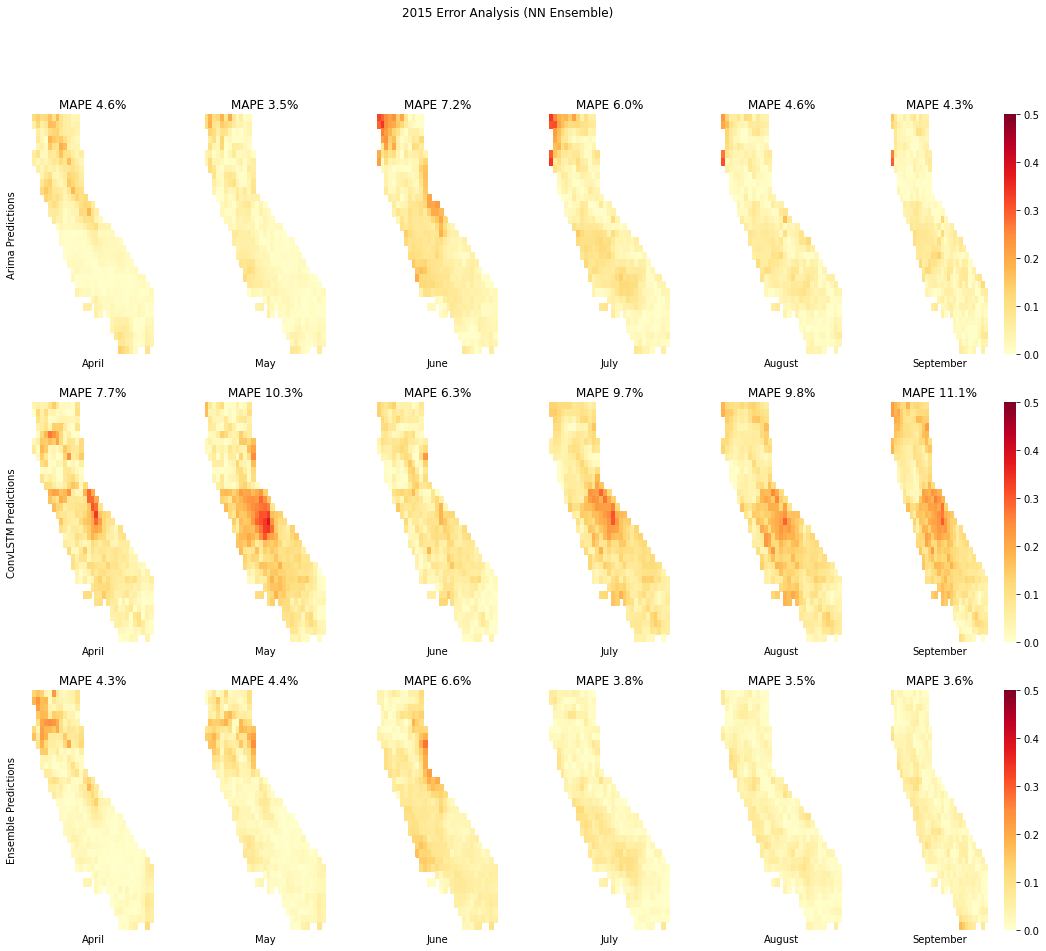

In [20]:
plot_mape(final_pred_df, 2015, "2015 Error Analysis (NN Ensemble)")

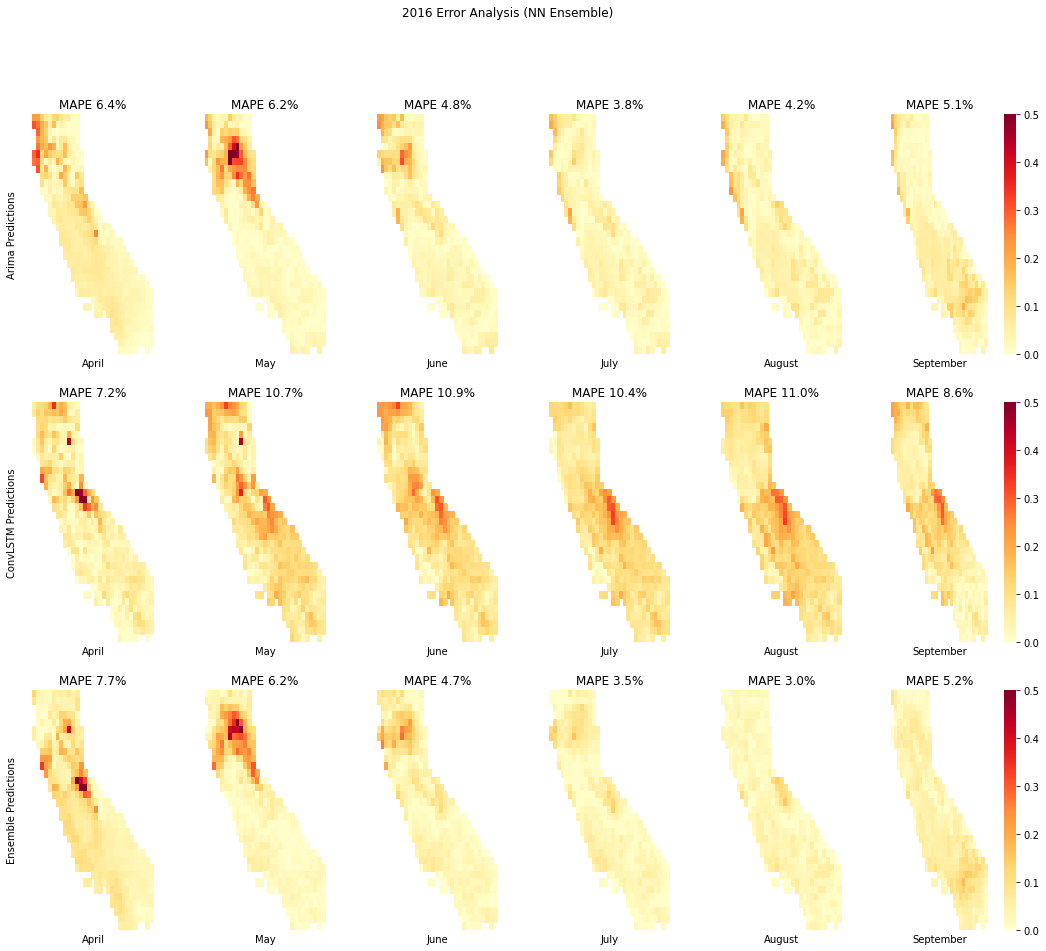

In [21]:
plot_mape(final_pred_df, 2016, "2016 Error Analysis (NN Ensemble)")